In [1]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import data

2022-12-06 20:23:20.634027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 20:23:20.777729: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 20:23:20.815652: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-06 20:23:21.492562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
# usando emb de 32 dim, word count 3, treinado 20 epocas, window 5

In [3]:
train_data = pd.read_csv("data/train_with_embeddings.csv")

In [4]:
train_data.columns

Index(['Unnamed: 0', 'text', 'retweets_count', 'favorites_count',
       'followers_count', 'statuses_count', 'friends_count', 'mentions',
       'urls', 'verified', 'hashtags', 'timestamp', 'TweetID', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
       '28', '29', '30', '31'],
      dtype='object')

In [5]:
train_data = train_data.drop(["Unnamed: 0"], axis=1)

In [6]:
# new features
train_data["url_count"] = train_data["urls"].apply(lambda s: s[1:-1].count("\'")/2)
train_data["text_len"] = train_data["text"].apply(lambda s: len(s))
train_data["hashtags_count"] = train_data["hashtags"].apply(lambda s: s[1:-1].count("\'")/2)
train_data["day"] = train_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).day)
train_data["hour"] = train_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).hour)
train_data["year"] = train_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).year)
train_data["month"] = train_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).month)

# text features
train_data["avg_word_len"] = train_data["text"].apply(lambda s: np.mean([len(w) for w in s.split()]))
train_data["rep_words_freq"] = train_data["text"].apply(lambda s: np.mean(len(list(set(s.split())))/len(s.split())))
train_data["rep_chars_freq"] = train_data["text"].apply(lambda s: np.mean(len(list(set(s)))/len(list(s))))
train_data["max_char_freq"] = train_data["text"].apply(lambda s: max( [s.count(c) for c in list(set(s))] )   /len(list(s)))
train_data["avg_word_count"] = train_data["text"].apply(lambda s: len(s.split()))

train_data["log"] = np.log(0.1 + train_data["favorites_count"])
train_data["sqrt"] = np.sqrt(train_data["favorites_count"])

# indicators of keywords
train_data["Macron"] =  train_data["text"].apply(lambda s: ("macron" in s.lower().split()))
train_data["Zemmour"] =  train_data["text"].apply(lambda s: ("zemmour" in s.lower().split()))
train_data["Vote"] =  train_data["text"].apply(lambda s: ("vote" in s.lower().split()) or ("votez" in s.lower().split()) or ("vot" in s.lower().split()))
# train_data["Melenchon"] =  train_data["text"].apply(lambda s: ("melenchon" in s.replace("é","e").lower().split()))

# train_data["rt"] =  train_data["text"].apply(lambda s: ("rt" in s.lower().split()))
train_data["rt"] =  train_data["text"].apply(lambda s: (s.lower().split()[0] == "rt"))    # changed!!

In [7]:
train_data = data.feature_words_arr(train_data)
train_data = data.feature_delete_stop_words(train_data, 'text_without_stopwords')
train_data = data.feature_sent_analysis(train_data, 'text_without_stopwords')
train_data = data.feature_abbrev(train_data)
display(train_data)
# # outlier removal
# train_data = train_data[train_data["retweets_count"] <= 40000]

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,...,sqrt,Macron,Zemmour,Vote,rt,text_arr,text_without_stopwords,polarity,subjectivity,abrev
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],...,0.0,True,False,False,True,"[rt, refarcir, macron, ans, nom, prépare]",rt refarcir macron ans nom prépare,0.00,0.000,0.000000
1,populaire,0,0,86,1016,284,[],[],0,[],...,0.0,False,False,False,False,[populaire],populaire,0.50,0.500,0.000000
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],...,1.0,False,False,False,False,"[faut, dégager, cinglé]",faut dégager cinglé,-0.01,-0.010,0.000000
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],...,0.0,False,False,False,False,"[enseignants, mettre, prescriptions, président...",enseignants mettre prescriptions président rép...,0.06,0.125,0.000000
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],...,0.0,True,False,False,False,"[mafieuse, oppressive, macron]",mafieuse oppressive macron,0.00,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,[],...,0.0,False,False,False,False,"[gonflette, tour, raciste, frustré]",gonflette tour raciste frustré,0.00,0.000,0.000000
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,[],...,0.0,False,False,False,False,"[france, caste, crapuleuse, encadrée, gangster...",france caste crapuleuse encadrée gangsters irr...,0.10,0.200,0.000000
353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,[],...,0.0,False,True,False,False,"[eric, zemmour, français, berbère]",eric zemmour français berbère,0.20,0.000,0.000000
353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,[],...,0.0,False,False,False,False,"[gauchistes, dépression, pq]",gauchistes dépression pq,0.00,0.000,0.333333


In [8]:
# from nltk.sentiment import SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()
# print("sentiment analysis...")
# train_data["compound"] =  train_data["text"].apply(lambda s: sia.polarity_scores(s)['compound'])

In [9]:
# select useful columns
train_data_filtered = train_data.drop(["text", "urls", "mentions", "hashtags", "timestamp", "TweetID",
                                        "text_arr", "text_without_stopwords"], axis=1)

In [10]:
# train_data_filtered = train_data.loc[:, ["retweets_count","favorites_count","followers_count","statuses_count","friends_count",
#                                  "hashtags_count","hour","verified","url_count","text_len","rt","Macron","Zemmour","Melenchon"]]


X_train, X_eval, y_train, y_eval = train_test_split(train_data_filtered.drop("retweets_count", axis=1),
                                                    train_data_filtered["retweets_count"],
                                                    random_state=42, test_size=0.1)

# Standardize the data
normal_columns = train_data_filtered.drop(["hour", "verified", "url_count", "rt", "retweets_count"], axis=1).columns
# normal_columns = train_data_filtered.drop(["hour", "verified", "url_count", "rt", "retweets_count"], axis=1).columns
mu, sigma = X_train[normal_columns].mean(axis=0), X_train[normal_columns].std(axis=0)
X_train.loc[:, normal_columns] = (X_train[normal_columns] - mu) / sigma
X_eval.loc[:, normal_columns] = (X_eval[normal_columns] - mu) / sigma

In [11]:
import tensorflow as tf

In [43]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Dense(20, activation='relu'),
#   tf.keras.layers.Dense(20, activation='relu'),
#   tf.keras.layers.Dense(20, activation='relu'),
#   tf.keras.layers.Dense(1),
# ])

"""model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
])"""

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1),
])

"""model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation='relu'),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(1),
])"""

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(1),
# ])

"model = tf.keras.models.Sequential([\n    tf.keras.layers.Dense(40, activation='relu'),\n    # tf.keras.layers.Dropout(0.1),\n    tf.keras.layers.Dense(40, activation='relu'),\n    tf.keras.layers.Dense(1),\n])"

In [39]:
# model.compile(optimizer="adam", loss='mae')

In [44]:
import tensorflow_addons as tfa
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-6)
model.compile(optimizer=optimizer, loss='mae')

In [68]:
history = model.fit(X_train.values.astype(np.float32), y_train.values.astype(np.float32), epochs=48, batch_size=1024,
         validation_data=(X_eval.values.astype(np.float32), y_eval.values.astype(np.float32)), shuffle=True)

Epoch 1/20
312/312 [==============================] - 1s 2ms/step - loss: 5.4847 - val_loss: 5.5762
Epoch 2/20
312/312 [==============================] - 0s 1ms/step - loss: 5.4703 - val_loss: 5.6186
Epoch 3/20
312/312 [==============================] - 1s 2ms/step - loss: 5.4545 - val_loss: 5.5620
Epoch 4/20
312/312 [==============================] - 1s 2ms/step - loss: 5.4288 - val_loss: 5.6206
Epoch 5/20
312/312 [==============================] - 1s 2ms/step - loss: 5.4176 - val_loss: 5.6157
Epoch 6/20
312/312 [==============================] - 1s 2ms/step - loss: 5.4238 - val_loss: 5.5922
Epoch 7/20
312/312 [==============================] - 1s 2ms/step - loss: 5.4030 - val_loss: 5.6367
Epoch 8/20
312/312 [==============================] - 1s 2ms/step - loss: 5.3892 - val_loss: 5.6245
Epoch 9/20
312/312 [==============================] - 1s 2ms/step - loss: 5.4135 - val_loss: 5.6525
Epoch 10/20
312/312 [==============================] - 1s 2ms/step - loss: 5.3783 - val_loss: 5.5769

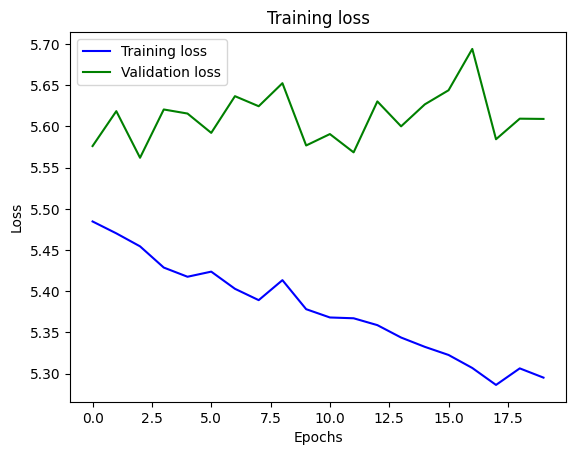

In [69]:
plt.plot(history.epoch, history.history["loss"], 'b', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
model.evaluate(X_eval.values.astype(np.float32),  y_eval.values.astype(np.float32), verbose=2)

1107/1107 - 1s - loss: 5.6037 - 679ms/epoch - 614us/step


5.603736877441406

In [48]:
pred = model.predict(X_eval.values.astype(np.float32))
print(pred)

1107/1107 [==============================] - 0s 389us/step
[[-2.6853001e-03]
 [-1.0917699e-03]
 [ 6.2853563e-01]
 ...
 [-2.8142845e-03]
 [-3.0687368e-03]
 [ 1.6729181e+01]]


In [49]:
eval_data = X_eval.copy()
eval_data ["groundtruth"] = y_eval
eval_data["pred"] = pred

In [50]:
eval_data

,favorites_count,followers_count,statuses_count,friends_count,verified,0,1,2,3,4,...,sqrt,Macron,Zemmour,Vote,rt,polarity,subjectivity,abrev,groundtruth,pred
307625,-0.055089,-0.077407,-0.334165,-0.497254,0,1.659951,1.260441,-1.153281,0.314119,-1.681024,...,-0.246756,-0.601175,-0.379343,-0.257806,False,0.794312,-0.754931,-0.389772,0,-0.002685
52950,-0.055089,-0.077779,-0.408998,-0.502035,0,1.607378,0.328137,-1.410871,-1.100783,-1.638529,...,-0.246756,-0.601175,-0.379343,-0.257806,False,0.989324,0.480421,-0.389772,0,-0.001092
289882,-0.055089,-0.067681,2.979071,1.399853,0,1.007636,-1.711462,-1.069517,-0.976684,1.441044,...,-0.246756,-0.601175,-0.379343,-0.257806,True,-1.459153,0.963819,-0.389772,0,0.628536
17637,-0.055089,-0.075549,0.847381,-0.566985,0,0.549285,1.078439,0.109340,-0.835755,0.671844,...,-0.246756,-0.601175,-0.379343,-0.257806,True,0.144274,0.534132,2.679304,0,0.056327
339255,-0.053906,-0.028786,-0.027463,0.115989,0,0.740793,1.850542,0.874007,0.992360,-0.676857,...,-0.095813,1.663403,-0.379343,-0.257806,False,-0.072405,-0.754931,-0.389772,1,1.311064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308634,-0.055089,-0.071539,0.205442,0.380173,0,0.212282,0.000731,-0.220809,-0.582526,0.462151,...,-0.246756,-0.601175,-0.379343,-0.257806,False,-0.072405,-0.754931,-0.389772,3,0.090964
276530,-0.053906,-0.077630,-0.393446,-0.539890,0,-1.104100,0.471199,-0.114141,-1.280227,-1.860396,...,-0.095813,-0.601175,-0.379343,-0.257806,False,0.216501,-0.110400,-0.389772,3,1.048473
302150,-0.055089,-0.076848,-0.012975,-0.174096,0,-0.294150,-0.265219,0.010878,0.323343,0.885406,...,-0.246756,-0.601175,-0.379343,-0.257806,False,-0.397424,-0.325244,1.802425,0,-0.002814
55651,-0.055089,-0.077729,-0.401657,-0.502434,0,0.402766,0.210234,-0.945661,0.152839,-0.230660,...,-0.246756,-0.601175,-0.379343,3.878877,False,-0.072405,-0.754931,-0.389772,0,-0.003069


In [51]:
# eval_data.to_csv("pred_example_58")

In [52]:
# plt.scatter(X_train["favorites_count"], model.predict(X_train))
# plt.scatter(X_train["favorites_count"], y_train.values.astype(np.float32))

In [58]:
# evaluation

eval_data = pd.read_csv("data/evaluation_with_embeddings.csv")
eval_data = eval_data.drop(["Unnamed: 0"], axis=1)
tweets = eval_data["TweetID"]

In [59]:
eval_data["url_count"] = eval_data["urls"].apply(lambda s: s[1:-1].count("\'")/2)
eval_data["text_len"] = eval_data["text"].apply(lambda s: len(s))
eval_data["hashtags_count"] = eval_data["hashtags"].apply(lambda s: s[1:-1].count("\'")/2)
eval_data["day"] = eval_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).day)
eval_data["hour"] = eval_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).hour)
eval_data["year"] = eval_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).year)
eval_data["month"] = eval_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).month)

# eval_data["Macron"] =  eval_data["text"].apply(lambda s: ("macron" in s.lower().split()))
# eval_data["Zemmour"] =  eval_data["text"].apply(lambda s: ("zemmour" in s.lower().split()))
# eval_data["Melenchon"] =  eval_data["text"].apply(lambda s: ("melenchon" in s.lower().split()))
eval_data["avg_word_len"] = eval_data["text"].apply(lambda s: np.mean([len(w) for w in s.split()]))
eval_data["rep_words_freq"] = eval_data["text"].apply(lambda s: np.mean(len(list(set(s.split())))/len(s.split())))
eval_data["rep_chars_freq"] = eval_data["text"].apply(lambda s: np.mean(len(list(set(s)))/len(list(s))))
eval_data["max_char_freq"] = eval_data["text"].apply(lambda s: max( [s.count(c) for c in list(set(s))] )/len(list(s)))
eval_data["avg_word_count"] = eval_data["text"].apply(lambda s: len(s.split()))

eval_data["log"] = np.log(0.1 + eval_data["favorites_count"])
eval_data["sqrt"] = np.sqrt(eval_data["favorites_count"])

# indicators of keywords
train_data["Macron"] =  train_data["text"].apply(lambda s: ("macron" in s.lower().split()))
train_data["Zemmour"] =  train_data["text"].apply(lambda s: ("zemmour" in s.lower().split()))
train_data["Vote"] =  train_data["text"].apply(lambda s: ("vote" in s.lower().split()) or ("votez" in s.lower().split()) or ("vot" in s.lower().split()))

# indicators of keywords
eval_data["Macron"] =  eval_data["text"].apply(lambda s: ("macron" in s.lower().split()))
eval_data["Zemmour"] =  eval_data["text"].apply(lambda s: ("zemmour" in s.lower().split()))
eval_data["Vote"] =  eval_data["text"].apply(lambda s: ("vote" in s.lower().split()) or ("votez" in s.lower().split()) or ("vot" in s.lower().split()))
# train_data["Melenchon"] =  train_data["text"].apply(lambda s: ("melenchon" in s.replace("é","e").lower().split()))

# train_data["rt"] =  train_data["text"].apply(lambda s: ("rt" in s.lower().split()))
eval_data["rt"] =  eval_data["text"].apply(lambda s: (s.lower().split()[0] == "rt"))    # changed!!

# print("sentiment analysis...")
# eval_data["compound"] =  eval_data["text"].apply(lambda s: sia.polarity_scores(s)['compound'])

eval_data = data.feature_words_arr(eval_data)
eval_data = data.feature_delete_stop_words(eval_data, 'text_without_stopwords')
eval_data = data.feature_sent_analysis(eval_data, 'text_without_stopwords')
eval_data = data.feature_abbrev(eval_data)

eval_data = eval_data.drop(["text", "urls", "mentions", "hashtags", "timestamp", "TweetID",
                                        "text_arr", "text_without_stopwords"], axis=1)

# normalize
eval_data.loc[:, normal_columns] = (eval_data.loc[:, normal_columns] - mu) / sigma

display(eval_data)

,favorites_count,followers_count,statuses_count,friends_count,verified,0,1,2,3,4,...,avg_word_count,log,sqrt,Macron,Zemmour,Vote,rt,polarity,subjectivity,abrev
0,-0.055089,-0.077561,-0.384487,-0.451430,0,0.000738,-0.827161,-0.165913,-0.086488,0.335220,...,-1.214200,-0.564477,-0.246756,-0.601175,-0.379343,3.878877,False,-0.072405,-0.754931,-0.389772
1,-0.055089,-0.076250,-0.130940,-0.405207,0,-0.140195,-0.817307,0.445312,-0.190840,0.682034,...,-1.019999,-0.564477,-0.246756,-0.601175,-0.379343,-0.257806,False,-0.072405,-0.754931,-0.389772
2,-0.047990,-0.073569,-0.308274,0.054226,0,0.331631,-1.551471,0.577129,0.500906,0.824197,...,-0.631597,1.216190,0.122977,-0.601175,-0.379343,-0.257806,False,-0.072405,1.393507,-0.389772
3,-0.052722,-0.071378,-0.197070,0.229552,0,0.757116,-2.875776,2.891350,3.095130,0.305862,...,1.310413,0.754289,-0.033291,1.663403,-0.379343,3.878877,False,-0.939123,0.319288,0.569314
4,-0.055089,-0.076932,-0.241396,-0.434694,0,-0.004402,-3.323222,1.639834,1.293254,1.202535,...,1.504614,-0.564477,-0.246756,-0.601175,2.636129,-0.257806,False,-0.289085,0.405225,-0.389772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117985,-0.055089,-0.077871,-0.421834,-0.556227,0,-0.067105,-0.899418,0.230043,-0.062717,0.436172,...,-1.019999,-0.564477,-0.246756,-0.601175,-0.379343,3.878877,False,-0.072405,-0.754931,-0.389772
117986,-0.055089,-0.075036,-0.076371,-0.225498,0,-0.353704,-1.108917,0.237334,0.625011,0.212448,...,1.698815,-0.564477,-0.246756,-0.601175,-0.379343,-0.257806,False,-0.072405,-0.754931,-0.389772
117987,-0.040891,-0.074347,-0.403582,-0.518372,0,-0.044470,-1.529406,0.130219,1.074033,0.150446,...,0.145207,1.512869,0.276125,1.663403,-0.379343,-0.257806,False,-1.480821,1.393507,-0.389772
117988,-0.055089,-0.077867,-0.423504,-0.549851,0,-1.222857,-1.809126,1.924704,1.314657,-0.172334,...,1.504614,-0.564477,-0.246756,-0.601175,-0.379343,-0.257806,False,2.094389,3.112258,0.512898


In [60]:
display(X_train)

,favorites_count,followers_count,statuses_count,friends_count,verified,0,1,2,3,4,...,avg_word_count,log,sqrt,Macron,Zemmour,Vote,rt,polarity,subjectivity,abrev
286184,-0.055089,-0.077844,-0.421579,-0.525943,0,-0.483942,-0.545502,-0.670232,-0.585232,0.811290,...,-0.243195,-0.564477,-0.246756,-0.601175,-0.379343,-0.257806,False,-0.072405,-0.754931,-0.389772
83577,-0.055089,-0.067811,-0.070867,0.325185,0,0.125684,0.266945,-1.008677,1.457794,-0.064329,...,0.533609,-0.564477,-0.246756,-0.601175,-0.379343,3.878877,False,0.924320,-0.038785,-0.389772
165861,-0.055089,-0.077714,-0.417499,-0.523552,0,-1.389942,-0.621829,-0.677483,-0.283926,-0.031527,...,-0.631597,-0.564477,-0.246756,-0.601175,-0.379343,-0.257806,False,-0.072405,-0.754931,-0.389772
314938,-0.045624,-0.071025,-0.322850,-0.292042,0,2.695700,-2.615844,2.083146,-2.640631,1.321818,...,0.727810,1.339024,0.180175,-0.601175,-0.379343,-0.257806,False,-1.394150,1.715773,-0.389772
301981,-0.052722,-0.076427,-0.310814,-0.221115,0,-0.193663,-0.496109,0.843026,-0.721525,-0.353385,...,1.310413,0.754289,-0.033291,-0.601175,-0.379343,-0.257806,False,0.490961,0.383741,-0.389772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.055089,-0.074569,-0.374245,-0.252993,0,0.879953,-0.683609,1.136954,-1.084442,1.196275,...,-0.437396,-0.564477,-0.246756,-0.601175,-0.379343,-0.257806,False,-0.072405,-0.754931,-0.389772
259178,-0.055089,-0.067190,-0.409402,-0.420349,0,-0.644403,0.276622,-0.162172,0.186636,-0.227735,...,-0.243195,-0.564477,-0.246756,1.663403,-0.379343,-0.257806,False,-1.372482,1.393507,-0.389772
131932,-0.055089,-0.062559,-0.417992,0.397706,0,0.456242,0.153781,0.097585,0.466508,-0.887893,...,0.533609,-0.564477,-0.246756,-0.601175,-0.379343,-0.257806,False,-0.072405,-0.754931,0.889010
146867,-0.055089,-0.076515,-0.175583,-0.372135,0,0.173674,-0.724927,-0.126602,0.451470,-0.001237,...,2.281418,-0.564477,-0.246756,-0.601175,2.636129,3.878877,False,2.744427,1.823195,0.340960


In [64]:
X_train.columns

Index(['favorites_count', 'followers_count', 'statuses_count', 'friends_count',
       'verified', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', 'url_count',
       'text_len', 'hashtags_count', 'day', 'hour', 'year', 'month',
       'avg_word_len', 'rep_words_freq', 'rep_chars_freq', 'max_char_freq',
       'avg_word_count', 'log', 'sqrt', 'Macron', 'Zemmour', 'Vote', 'rt',
       'polarity', 'subjectivity', 'abrev'],
      dtype='object')

In [65]:
eval_data.columns

Index(['favorites_count', 'followers_count', 'statuses_count', 'friends_count',
       'verified', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', 'url_count',
       'text_len', 'hashtags_count', 'day', 'hour', 'year', 'month',
       'avg_word_len', 'rep_words_freq', 'rep_chars_freq', 'max_char_freq',
       'avg_word_count', 'log', 'sqrt', 'Macron', 'Zemmour', 'Vote', 'rt',
       'polarity', 'subjectivity', 'abrev'],
      dtype='object')

In [66]:
pred = model.predict(eval_data.values.astype(np.float32))

print(pred)

# output normalization
for i,p in enumerate(pred):
    if p<0: pred[i] = 0

3688/3688 [==============================] - 2s 466us/step
[[ 1.1642659e-03]
 [ 3.7730578e-04]
 [ 3.3550127e+00]
 ...
 [ 3.9239931e+00]
 [-1.4178669e-03]
 [-2.5429642e-03]]


In [67]:
with open("data/predictions.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "retweets_count"])
    for index, prediction in enumerate(pred):
        writer.writerow([str(tweets[index]) , str(int(prediction))])